# Interpolación spline con Python

Autor: Pedro González Rodelas

Fecha de la primera versión: 27/08/1017

Fecha de la última revisión: 22/10/2017

Estructura del notebook y algunos ejemplos tomados o adaptados de los libros:

- "Numerical Python: A Practical Techniques Approach for Industry" de Robert Johansson. Edit. Apress (2015) con ISBN-13 (electronic): 978-1-4842-0553-2
- "Numerical Methods in Engineering with Python 3" de Jaan Kiusalaas. Edit Cambridge Univ. Press (2013) con ISBN: 978-1-107-03385-6
- "Análisis Numérico con Mathematica" de V. Ramírez, D. Barrera, M. Pasadas y P. González. Edit. Ariel Ciencia (2001) con ISBN: 84-344-8036-0. Dep. Legal: B.31.425-2001

En esta práctica nos ocuparemos de varias de las posibilidades que tenemos para definir y trabajar con splines en **Python**, bien sea usando órdenes específicas de alguno de sus módulos, o bien usando las herramientas y funciones básicas desarrolladas en la práctica sobre *Interpolación*. 

## Carga de los módulos y Definición de ciertas funciones empleadas

Antes de empezar a realizar cualquier cálculo numérico o simbólico debemos de cargar los correspondientes módulos de Python que implementan la mayoría de funciones y procedimientos necesarios para ello: `NumPy` y `SymPy`, que serán cargados con los pseudónimos `np` y `sp`, respectivamente. Además cargaremos la función del módulo `random` que nos permitirá generar números aleatorios, cada vez que los necesitemos.

In [1]:
import numpy as np # Importamos el módulo NumPy con el pseudónimo np
import sympy as sp # Importamos el módulo SymPy con el pseudónimo sp
sp.init_printing()

In [2]:
# usaremos una opción para poder visualizar los gráficos incrustados 
# en línea dentro de este mismo notebook
%matplotlib inline 
import matplotlib.pyplot as plt  # 

In [3]:
import numpy.polynomial as P # cargaremos el submódulo polynomial, 
# situado dentro del módulo NumPy, con el pseudónimo P

In [5]:
from scipy import interpolate # importamos el submódulo interpolate
?interpolate

In [4]:
from random import random 
# Importamos la función generadora de números pseudoaleatorios

También definiremos cierta función propia, `mychop`, que nos permitirá cambiar por $0$ cualquier valor que obtengamos, después de ciertos cálculos que involucren errores de redondeo, propios del cálculo con números en coma flotante. A su vez usaremos una versión vectorizada de la misma, que podremos aplicar a cualquier lista, tupla o array con valores numéricos en coma flotante.

In [7]:
def mychop(expr, *, max=10**(-15)): 
    if abs(expr) > max:
      return expr 
    else:
      return 0

chop_vec = np.vectorize(mychop)

Por otro lado, usaremos muchas de las funciones que obtuvimos en la práctica sobre interpolación, con el objeto de poder resolver rápida y cómodamente muchos de los problemas habituales que nos encontraremos a la hora de construir diversos tipos de splines uniendo trozos de polinomios que satisfacen ciertos datos de interpolación lagrangiana y/o de tipo Hermite.

In [8]:
x = sp.Symbol('x')
xL,yL,xM,yM,xR,yR = sp.symbols('xL,yL,xM,yM,xR,yR')
x1,y1,x2,y2,x3,y3,x4,y4 = sp.symbols('x1,y1,x2,y2,x3,y3,x4,y4')
d,dL,dR,d2L,d2R = sp.symbols('d,dL,dR,d2L,d2R')
D,D1,D2 = sp.symbols('DR,D1,D2')

def linea(x,xL,yL,xR,yR):
    """linea que pasa por los puntos (xL,yL) y (xR,yR)"""
    return yL+(x-xL)*(yL-yR)/(xL-xR)

def parabola(x,xL,yL,xM,yM,xR,yR):
    """parábola que pasa por tres puntos"""
    return yL -(x-xL)*(x-xM)*(xL*yM-xL*yR-xM*yL+xM*yR+xR*yL-xR*yM)
          /(xL**2*xM-xL**2*xR-xL*xM**2+xL*xR**2+xM**2*xR-xM*xR**2)
          +(x-xL)*(yL-yM)/(xL-xM)

def parabolaconderivada(x,d,xL,yL,xR,yR):
    """parábola con derivada fijada en el primer punto"""
    return (yL*(xL-xR)**2+(x-xL)*(x-xR)*(d*(xL-xR)+(yR-yL))
            +(x-xL)*(xL-xR)*(yL-yR))/(xL-xR)**2

def cubica(x,x1,y1,x2,y2,x3,y3,x4,y4):
    """cúbica que pasa por cuatro puntos dados"""
    return y1+(x-x1)*(x-x2)*(x-x3)*(x1**2*x2*y3-x1**2*x2*y4
        -x1**2*x3*y2+x1**2*x3*y4+x1**2*x4*y2-x1**2*x4*y3
        -x1*x2**2*y3+x1*x2**2*y4+x1*x3**2*y2-x1*x3**2*y4
        -x1*x4**2*y2+x1*x4**2*y3+x2**2*x3*y1-x2**2*x3*y4
        -x2**2*x4*y1+x2**2*x4*y3-x2*x3**2*y1+x2*x3**2*y4
        +x2*x4**2*y1-x2*x4**2*y3+x3**2*x4*y1-x3**2*x4*y2
        -x3*x4**2*y1+x3*x4**2*y2)/(x1**3*x2**2*x3-x1**3*x2**2*x4
        -x1**3*x2*x3**2+x1**3*x2*x4**2+x1**3*x3**2*x4-x1**3*x3*x4**2
        -x1**2*x2**3*x3+x1**2*x2**2*x4+x1**2*x2*x3**3-x1**2*x2*x4**3
        -x1**2*x3**3*x4+x1**2*x3*x4**3+x1*x2**3*x3**2-x1*x2**3*x4**2
        -x1*x2**2*x3**3+x1*x2**2*x4**3+x1*x3**3*x4**2-x1*x3**2*x4**3
        -x2**3*x3**2*x4+x2**3*x3*x4**2+x2**2*x3**3*x4-x2**2*x3*x4**3
        -x2*x3**3*x4**2+x2*x3**2*x4**3)-(x-x1)*(x-x2)*(x1*y2-x1*y3
        -x2*y1+x2*y3+x3*y1-x3*y2)/(x1**2*x2-x1**2*x3-x1*x2**2
        +x1*x3**2+x2**2*x3-x2*x3**2)+(x-x1)*(y1-y2)/(x1-x2)

def cubicaconderivadas(x,xL,yL,dL,xR,yR,dR):
    """cúbica con datos de Lagrange y Hermite en ambos extremos"""
    D = (dL*xL-dL*xR+dR*xL-dR*xR-2*(yL-yR))/(xL-xR)**3
    return parabolaconderivada(x,dL,xL,yL,xR,yR) 
                             + D*(x-xL)**2*(x-xR)

def quintica(x,xL,yL,dL,d2L,xR,yR,dR,d2R):
    """quíntica con datos de Lagrange y Hermite en ambos extremos"""
    D1 = (d2L*xL**2/2 - d2L*xL*xR + d2L*xR**2/2 - 2*dL*xL + 2*dL*xR 
          - dR*xL + dR*xR + 3*yL - 3*yR)/(xL**4 - 4*xL**3*xR 
          + 6*xL**2*xR**2 - 4*xL*xR**3 + xR**4)
    D2 = (d2L*xL**2 - 2*d2L*xL*xR + d2L*xR**2 - d2R*xL**2 
          + 2*d2R*xL*xR - d2R*xR**2 - 6*dL*xL + 6*dL*xR - 6*dR*xL 
          + 6*dR*xR + 12*yL - 12*yR)/(2*(xL**5 - 5*xL**4*xR 
          + 10*xL**3*xR**2 - 10*xL**2*xR**3 + 5*xL*xR**4 - xR**5))
    return cubicaconderivadas(x,xL,yL,dL,xR,yR,dR) 
         + D1*(x-xL)**2*(x-xR)**2 + D2*(x-xL)**3*(x-xR)**2

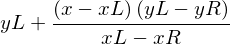

In [9]:
linea(x,xL,yL,xR,yR)

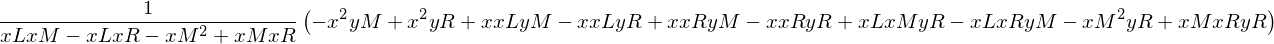

In [10]:
parabola(x,xL,yR,xM,yM,xR,yR).simplify()

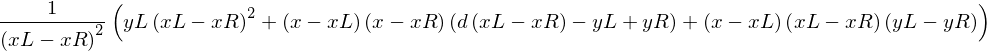

In [11]:
parabolaconderivada(x,d,xL,yL,xR,yR).simplify()

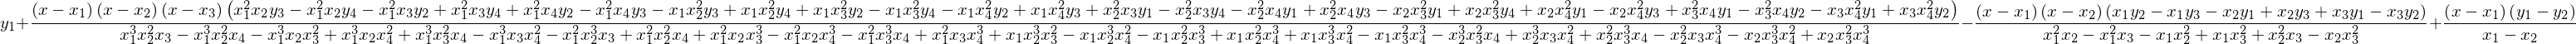

In [12]:
cubica(x,x1,y1,x2,y2,x3,y3,x4,y4).simplify()

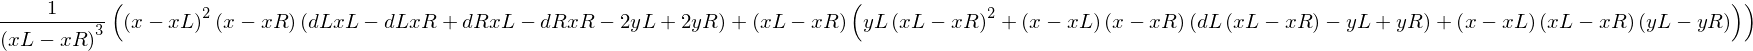

In [13]:
cubicaconderivadas(x,xL,yL,dL,xR,yR,dR).simplify()

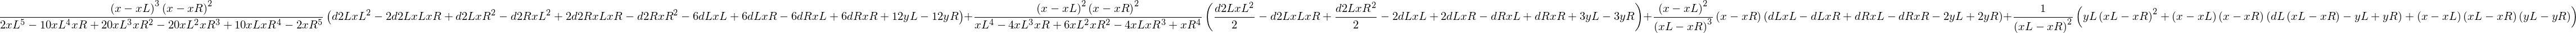

In [16]:
quintica(x,xL,yL,dL,d2L,xR,yR,dR,d2R).simplify()

## Interpolación spline de Lagrange

## Spline de interpolación lineal de clase $C^0$

En esta sección se muestra cómo obtener un spline lineal de interpolación una vez especificados los nodos de interpolación, $x_0, x_1, \ldots, x_n$, y los valores que deben ser interpolados,  $y_0, y_1, \ldots, y_n$. El correspondiente espacio de poligonales continuas se suele denotar $S_1(x_0, x_1,\ldots,x_n)$.

Especificamos unos nodos concretos.

In [5]:
x = [0, sp.pi/4, sp.pi/2, (3*sp.pi)/4, sp.pi]
n = len(x)-1
n

In [6]:
z = sp.Symbol('z')
def f(z):
    return sp.sin(z)
f_vec = np.vectorize(f)

In [7]:
y = f_vec(x)
print(y)

[0 sqrt(2)/2 1 sqrt(2)/2 0]


In [28]:
sp.diff(f(z),z),sp.diff(f(z),z,2)

In [8]:
def df(z):
    return sp.cos(z)
df_vec = np.vectorize(df)

In [9]:
def d2f(z):
    return -sp.sin(z)
d2f_vec = np.vectorize(d2f)

In [45]:
df_vec(x)

array([1, sqrt(2)/2, 0, -sqrt(2)/2, -1], dtype=object)

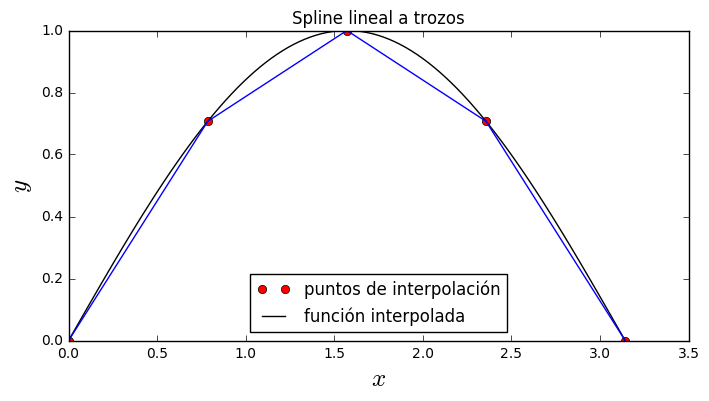

In [31]:
nxx = 100
nzz = nxx/(n+1)
xx = np.linspace(float(x[0]),float(x[-1]),nxx)
yy = f_vec(xx)
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    yk = [linea(z,x[k-1],y[k-1],x[k],y[k]) for z in zz]
    plt.plot(zz,yk,'b');

ax.legend(loc=8)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Spline lineal a trozos');

Por otra parte, ya que en cada uno de los subintervalos $[x_{i-1},x_i]$ dicha poligonal no es más que el segmento de línea recta que une los puntos $(x_{i-1},y_{i-1})$ y $(x_i,y_i)$, podríamos obtener fácilmente la expresión correspondiente:

$$y_i(x)=\frac{y_i-y_{i-1}}{x_i-x_{i-1}}(x-x_{i-1})+y_{i-1}, \forall x \in [x_{i-1},x_i]\quad (1)$$

#### Distintas bases del espacio $S_1(x_0,\ldots,x_n)$

Otro aspecto muy importante cuando se trabaja con splines, o con cualquier otro espacio de funciones de dimensión finita, es considerar las bases apropiadas que nos permitirán trabajar mejor con los correspondientes elementos que los componen. Por ejemplo en este caso de splines lineales, podemos considerar distintas bases, cada una con sus propias ventajas o inconvenientes, de manera que algunas de ellas también se podrán generalizar a otros splines de grado mayor, como veremos.

#### Base de potencias truncadas lineales

Una de las bases que pueden ser consideradas en este caso y que se generaliza fácilmente a otro tipo de splines, se basa en el concepto de potencia truncada, que definiremos a continuación.

In [14]:
z,m = sp.symbols('z,m')
def potrunc(z,m):
    """potencia truncada z_m^m"""
    return (z**m)*(z>0)

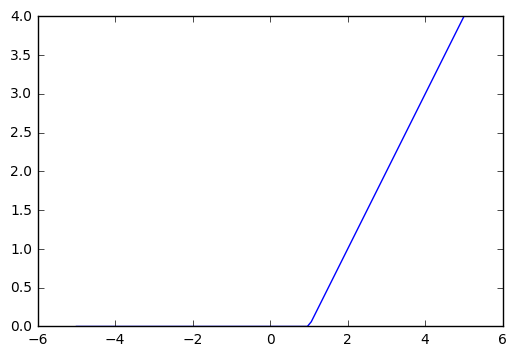

In [15]:
xx = np.linspace(-5,5,100) # dibujemos alguna de estas
c = 1; m = 1; yy = potrunc(xx-c,m) # potencias truncadas 
plt.plot(xx,yy); # cambie el valor de c y m para ver el efecto

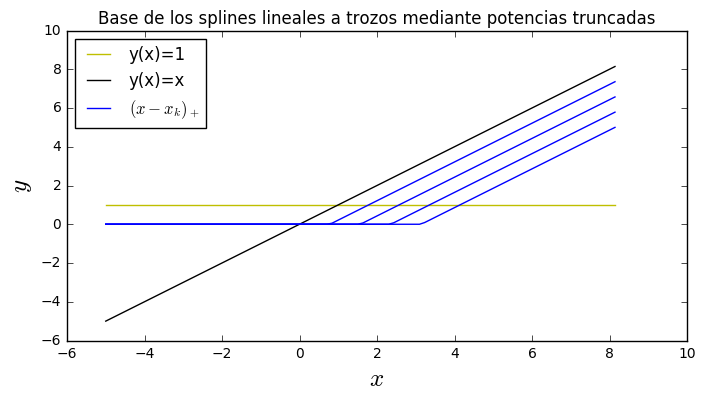

In [16]:
nxx = 100
xx = np.linspace(float(x[0]-5),float(x[-1]+5),nxx)

fig,ax = plt.subplots(figsize=(8,4))
yy = np.ones(nxx); plt.plot(xx,yy,'y',label='y(x)=1')
yy = xx; plt.plot(xx,yy,'k',label='y(x)=x')
for k in range(1,n):
    yy = potrunc(xx-float(x[k]),1)
    plt.plot(xx,yy,'b');  # ,label='$(x-x_i)_+$'
yy = potrunc(xx-float(x[n]),1)
plt.plot(xx,yy,'b',label='$(x-x_k)_+$')
ax.legend(loc=2)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Base de los splines lineales a trozos mediante potencias truncadas');

Nótese que la idea fundamental que motiva la elección de esta posible base

$$\{1,x,(x-x_1)_+,\ldots,(x-x_{n-1})_+ \} $$

es el hecho de que cuando le sumamos un múltiplo de una de estas potencias truncadas a cualquier polinomio de grado uno, le estaremos sumando una función contínua que vale cero justo hasta uno de los nodos en cuestión, y por lo tanto la modificación sólo tiene lugar justo a partir de dicho nodo, resultando así en otro trozo polinómico de grado uno, que podrá seguir siendo modificado más adelante, a partir del siguiente nodo, recuperando así de manera unívoca la poligonal total. Esta es justo la propiedad que las caracteriza como base de dicho espacio, ya que la independendia lineal está asegurada por construcción.

Así pues, nuestra función poligonal (o spline lineal) pasando por los puntos indicados $(x_0,y_0),\ldots,(x_n,y_n)$ tendrá la siguiente expresión:
$$s(x) = c_0+c_1 x+\sum_{k=2}^n c_k (x-x_{k-1})_+$$
de manera que los correspondientes coeficientes $c_0,c_1,\ldots,c_n$ tendrán que ser calculados a partir del sistema lineal resultante de imponer las correspondientes condiciones de interpolación $s(x_k)=y_k, \; k=0,1,\ldots,n$.


Además, como veremos fácilmente, estos coeficientes del sistema podrán ir obteniéndose poco a poco, a partir del primer segmento de recta que une los dos primeros puntos, sin más que ir resolviendo un nuevo sistema cada vez, con una incógnita y ecuación adicional.

Si denominamos $y_i(x)\equiv y|[x_{i-1},x_i]$, claramente la expresión que tomará el spline linear en dicho subintervalo será la ya indicada en $(1)$; pero además, expresada en términos de esta base de potencias truncadas tendrá la siguiente expresión

$$y_i(x) = c_0+c_1 x+\sum_{k=2}^{i} c_k (x-x_{k-1})$$

en la que todos los coeficientes $c_0,c_1,\ldots,c_{i-1}$ serán ya conocidos y sólo faltará por calcular el último $c_i$ a partir de la nueva condición a imponer $y_i(x_i)=y_i$. Bastará pues con aplicar sucesivamente este procedimiento hasta llegar al último subintervalo $[x_{n-1},x_n]$ para obtener el valor del último coeficiente $c_n$ imponiendo $y_n(x_n)=y_n$ y habríamos terminado.

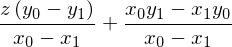

In [35]:
c0,c1 = sp.symbols('c0,c1')
x0,x1 = sp.symbols('x0,x1')
y0,y1 = sp.symbols('y0,y1')
ec0 = c0+c1*x0 - y0
ec1 = c0+c1*x1 - y1
sol1 = sp.solve([ec0,ec1],[c0,c1])
s1 = (c0+c1*z).subs(sol1)
s1 # Así obtendríamos el primer segmento de recta

In [36]:
s1.subs({z:x0}).simplify() # comprobando que s1(x0) = y0

In [37]:
s1.subs({z:x1}).simplify() # y que s1(x1) = y1

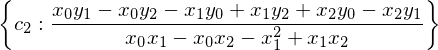

In [38]:
x2,y2,c2 = sp.symbols('x2,y2,c2')
ec2 = s1.subs({z:x2})+c2*(x2-x1)-y2
sol2 = sp.solve([ec2],[c2])
sol2 # y así el resto de coeficientes a determinar

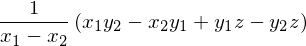

In [39]:
s2=(s1+(c2.subs(sol2))*(z-x1)).simplify()
s2

In [40]:
s2.subs({z:x2}).simplify() # comprobamos que efectivamente s2(x2)=y2

Así pues, ya tendríamos todos los coeficientes $c_0=\frac{x_1y_0-x_0y_1}{x_1-x_0}$, $c_1=\frac{y_1-y_0}{x_1-x_0}$ y los demás coeficientes $c_k$, para $k=2,\ldots,n$, los obtendríamos mediante este procedimiento. Veámos el resultado computacionalmente.

In [41]:
c = np.zeros(n+1)
c[0] = float((x[1]*y[0]-x[0]*y[1])/(x[1]-x[0]))
c[1] = float((y[1]-y[0])/(x[1]-x[0]))
s1 = c[0] + c[1]*z

ck = sp.Symbol('ck')
for k in range(2,n+1):
    eck = s1.subs({z:x[k]})+ck*(x[k]-x[k-1])-y[k]
    solk = sp.solve([eck],[ck])
    c[k] = ck.subs(solk)
    s2 = (s1+c[k]*(z-x[k-1])).simplify()
    s1 = s2
c

array([ 0.        ,  0.90031632, -0.52739309, -0.74584646, -0.52739309])

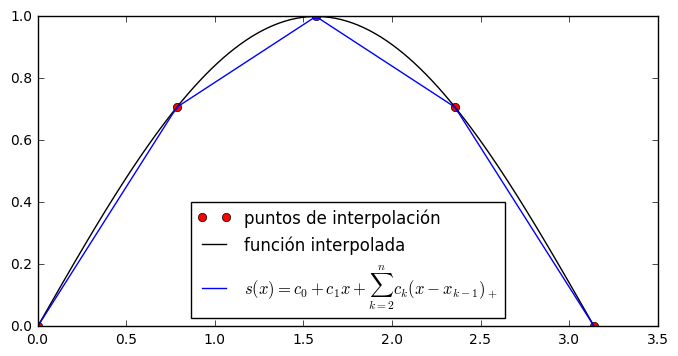

In [42]:
xx = np.linspace(float(x[0]),float(x[-1]),nxx)
yy = f_vec(xx)
ss = c[0]+c[1]*xx+sum([c[k]*potrunc(xx-float(x[k-1]),1) for k in range(2,n+1)])

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
ax.plot(xx,ss, label='$s(x)= c_0+c_1 x
        +\sum_{k=2}^n c_k (x-x_{k-1})_+$'); 
ax.legend(loc=8);

#### Base triangular (base del denominado Elemento Finito de Lagrange)

Hemos visto que podemos trabajar con estos splines lineales contínuos (conmunmente conocidos como poligonales) de distintas maneras y usando ciertas bases. Pero aún nos queda por considerar otra de las bases más interesantes desde el punto de vista computacional, ya que se podrá generalizar luego para definir el conocido método de los elementos finitos, de tipo Lagrange en este caso. Veámos en qué consiste la idea.

Lo que queremos es que, como ocurría ya con la base de Lagrange para la construcción del polinomio de interpolación mediante la fórmula que lleva su nombre, cada función de la base de splines lineales controle uno y sólo uno de los valores interpolados; es decir, que valga $1$ en uno de los nodos y $0$ en todos los demás.

Así pues, pretendemos construir una base del espacio $S_1(x_0,\ldots,x_n)$ de la forma $\{w_0(x),\ldots,w_i(x),\ldots,w_n(x)\}$ de manera que en todo caso se verifique que $w_i(x_k)=\delta_{i,j},\;\forall i,j\in \{0,\ldots,n\}$. 

La expresión analítica de una tal función de base será bastante fácil de obtener, ya que en todo caso sabemos que tiene que ser un spline lineal: osea, una sucesión contínua de trozos de polinomios de grado uno en cada uno de los subintervalos de la partición. Así pues, resulta evidente que en los nodos extremos de la partición

$w_0(x)=\{\frac{x-x_1}{x_0-x_1},\; x\in[x_0,x_1]$

$w_n(x)=\{\frac{x_n-x}{x_n-x_{n-1}},\; x\in[x_{n-1},x_n]$

mientras que en los nodos interiores de la partición
$$w_i(x)=
\begin{array}{lr}
\frac{x-x_{i-1}}{x_i-x_{i-1}} & x\in[x_{i-1},x_i]\\
\frac{x_{i+1}-x}{x_{i+1}-x_{i}} & x\in[x_{i},x_{i+1}]
\end{array}
$$

In [43]:
def w(z,i,x):
    """función base el E.F de Lagrange"""
    if x[i-1]<=z<=x[i]:
        return (z-x[i-1])/(x[i]-x[i-1])
    elif i<len(x)-1:
        return (x[i]<=z<=x[i+1])*(x[i+1]-z)/(x[i+1]-x[i])
    else:
        return 0

In [44]:
a = float(x[0]); b = float(x[-1])
n = len(x)-1;
x = np.linspace(a,b,n+1)
x

array([ 0.        ,  0.78539816,  1.57079633,  2.35619449,  3.14159265])

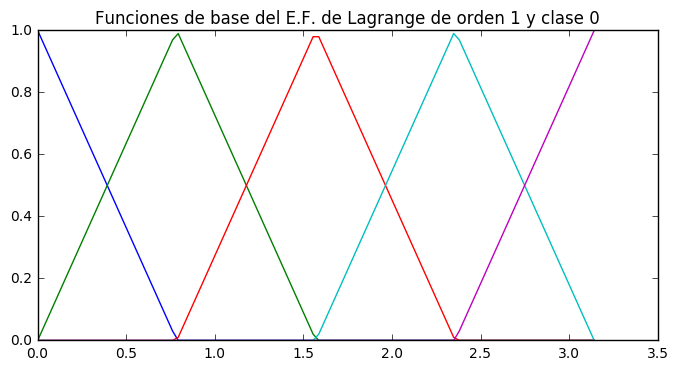

In [45]:
xx = np.linspace(a,b,100)

fig,ax = plt.subplots(figsize=(8,4))
for i in range(n+1):
    yy = [w(z,i,x) for z in xx]
    ax.plot(xx,yy)
ax.set_title('Funciones de base del E.F. de Lagrange de orden 1 y clase 0');

Podemos comprobar ahora que la poligonal o spline lineal que interpola los datos lagrangianos $(x_0,y_0),\ldots,(x_n,y_n)$ puede ser pues fácilmente expresada como combinación lineal de estas funciones de base triangulares (que como veremos en un tema posterior, constituyen la base asociada al Elemento Finito de Lagrange de orden 1 y clase 0), de la siguiente manera:

$$ s(x)= \sum_{i=0}^n y_i w_i(x)$$

ya que, por construcción,

$$ s(x_j)= \sum_{i=0}^n y_i w_i(x_j) = \sum_{i=0}^n y_i \delta_{i,j}=y_j,\quad \forall j\in\{0,\ldots,n\}$$

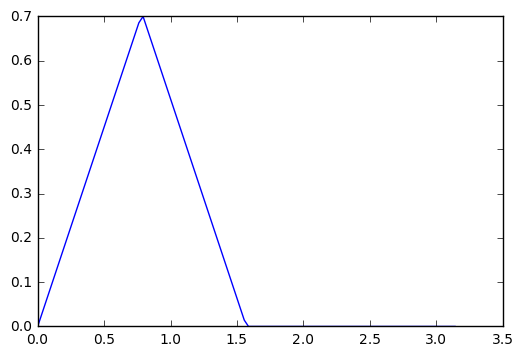

In [46]:
i=1
yy = [y[i]*w(z,i,x) for z in xx]
plt.plot(xx,yy);

In [47]:
y

array([0, sqrt(2)/2, 1, sqrt(2)/2, 0], dtype=object)

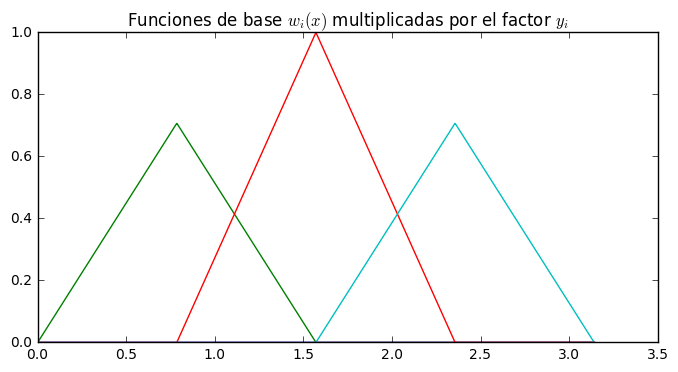

In [49]:
xx = np.linspace(x[0],x[-1],1000)
n = len(x)-1
fig,ax = plt.subplots(figsize=(8,4))
for i in range(n+1):
    yy = [y[i]*w(z,i,x) for z in xx]
    ax.plot(xx,yy)
ax.set_title('Funciones de base $w_i(x)$ 
             multiplicadas por el factor $y_i$');

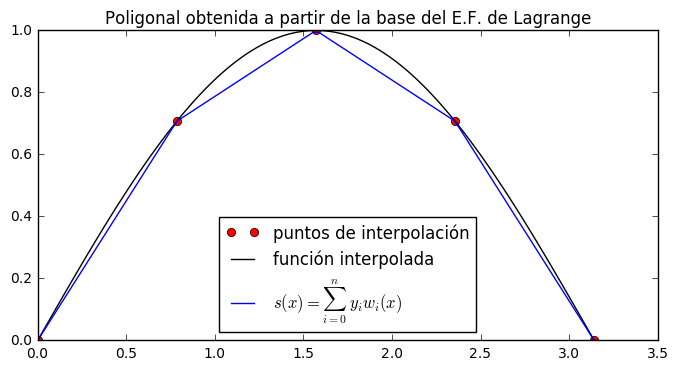

In [50]:
xx = np.linspace(float(x[0]),float(x[-1]),nxx)
yy = f_vec(xx)
ss = sum(np.array([[float(y[i])*w(z,i,x) for z in xx] 
                   for i in range(n+1)]))

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
ax.plot(xx,ss, label='$s(x)=\sum_{i=0}^n\; y_iw_i(x)$'); 
# gráfico del spline lineal
ax.legend(loc=8)
ax.set_title('Poligonal obtenida a partir de la base del E.F. 
             de Lagrange');

## Spline de interpolación cuadrática de clase $C^1$

En esta sección se muestra cómo obtener un *spline cuadrático* de interpolación, una vez especificados los nodos de interpolación ($x_0<x_1<\ldots...<x_n$) y los valores que deben ser interpolados  ($y_0, y_1, \ldots, y_n$).

In [51]:
x = [0, sp.pi/4, sp.pi/2, (3*sp.pi)/4, sp.pi]
n = len(x)-1
n

In [52]:
y

array([0, sqrt(2)/2, 1, sqrt(2)/2, 0], dtype=object)

Para obtener un *spline cuadrático* de interpolación, la restricción del spline $s(x)$ al intervalo $[x_{k-1},x_{k}]$ se puede expresar
como 
$$c_{k-1} + d_{k-1}\left(x-x_{k-1}\right)+\frac{e_{k-1}}{2}\left(x-x_{k-1}\right)^2,\; k=1,2,...,n$$ 

cumpliéndose que $c _{k-1}=y_{k-1}$ y $d_{k-1}=\frac{\Delta_k-y_k}{h_k}$,
donde $h_k=x_{k}-x_{k-1}$ y  $\Delta_k=\frac{y_{k}-y_{k-1}}{h_k}$. Los coeficientes  $d_k$ verifican las igualdades
$d_{k-1}+d_{k}=2\Delta_k,\; k=1,2,\ldots,n$.

Los valores $c_k=y_k$ se conocen directamente, y formamos una lista $y = (y_0,y_1,\ldots,y_n)$. Pero hay que calcular los valores $d_k$ y $e_k$, con $k\in\{0,1,\ldots,n\}$. Para ello determinamos las *amplitudes* $h_k$ y los *cocientes incrementales* $\Delta _k$, con los que formaremos otras dos listas (`h` y `D` respectivamente).

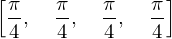

In [53]:
h = [x[k]-x[k-1] for k in range(1,n+1)]
h

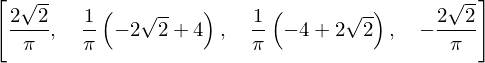

In [54]:
D = [(y[k]-y[k-1])/h[k-1] for k in range(1,n+1)]
D

En general, disponemos de $n-1$ ecuaciones para un total de  $n$ incógnitas. Debemos pues especificar el valor de al menos uno de los $d_k,\; k\in\{0,\ldots,n\}$ (por ejemplo $d_0$),
y calculamos los restantes a partir de la relación existente entre las incógnitas. Los valores calculados se irán almacenando en una
lista, que denominaremos simplemente $d$.

In [55]:
d = [1.]

Acabamos de indicar que el valor de $d_0$ es igual a la unidad, que precisamente es el valor exacto de la derivada de la función que queremos interpolar en el punto $x_0$. A continuación, calculamos recurrentemente los demás valores $d_k,\; k = 1,\ldots,n $.

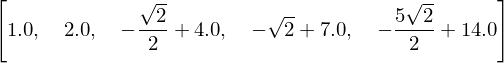

In [56]:
for k in range(n):         # Con este procedimiento vamos
    d.append(2*d[k]-y[k])  # añadiendo los valores d[k]
d                          # a la lista d.

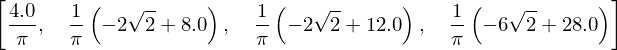

In [57]:
# Y ya estamos en condiciones de calcular la lista de valores e
e = [(d[k]-y[k])/h[k] for k in range(n)]
e

Y ya que se han calculado todos los parámetros necesarios, sólo quedará formar la función spline cuadrática que resuelve el problema
de interpolación de Lagrange y representarla gráficamente.

In [58]:
nxx = 100
nzz = nxx/(n+1)
xx = np.linspace(float(x[0]),float(x[-1]),nxx)
yy = f_vec(xx)

Para comparar la bondad de la aproximación representamos la función interpolada y mostramos su gráfica y la del spline de interpolación.

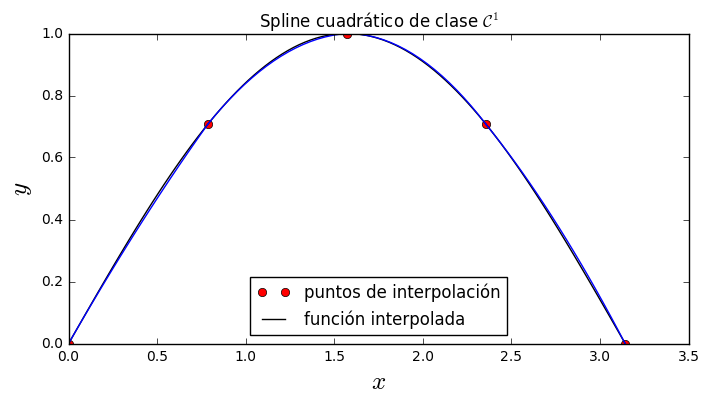

In [59]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    d = df(x[k-1])
    yk = [parabolaconderivada(z, d, x[k-1], y[k-1], x[k], y[k]) 
          for z in zz]
    plt.plot(zz,yk,'b');

ax.legend(loc=8)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Spline cuadrático de clase $\mathcal{C}^1$');

¿Se ha conseguido una buena aproximación?

Aparentemente sí, pero podemos representar gráficamente el error cometido para visualizarlo mucho mejor.

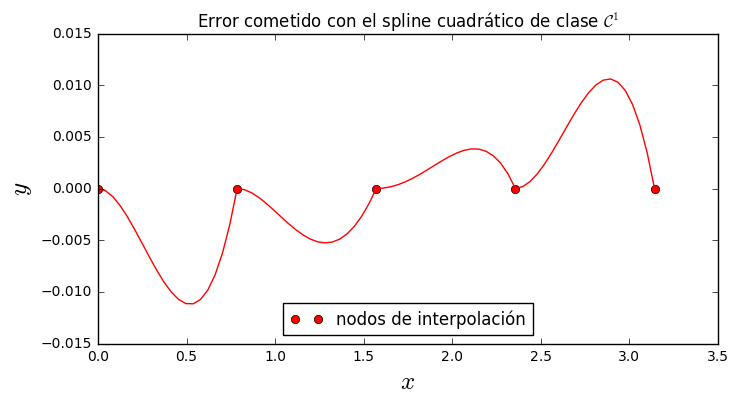

In [60]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,np.zeros(len(x)),'ro',label='nodos de interpolación')
# ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    d = df(x[k-1])
    errork = [parabolaconderivada(z, d, x[k-1], y[k-1], x[k], 
                                  y[k])-f(z) for z in zz]
    plt.plot(zz,errork,'r');

ax.legend(loc=8)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Error cometido con el spline cuadrático 
             de clase $\mathcal{C}^1$');

Vemos que, en todo caso, el error es nulo en cada uno de los nodos de interpolación. Por otra lado, al contrario de lo que pasaba con la interpolación polinomial clásica, la calidad global de la aproximación mediante la interpolación spline mejorará aumentando el número de nodos de interpolación.

#### Base de potencias truncadas cuadráticas

Otra posibilidad para obtener estos splines cuadráticos de clase $\mathcal{C}^1$ sería trabajar con la correspondiente base de potencias truncadas, que mostramos a continuación.

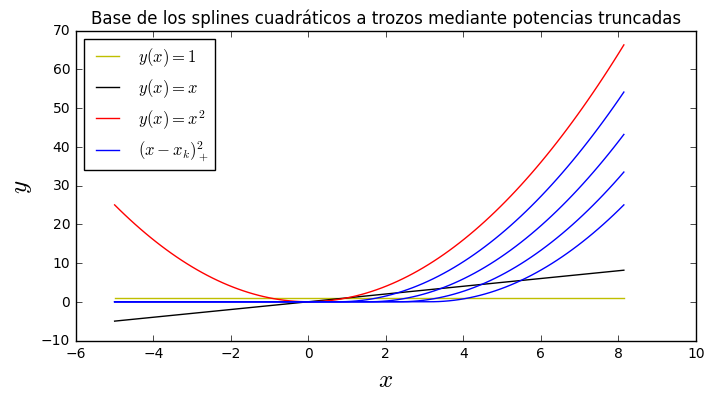

In [17]:
nxx = 100
xx = np.linspace(float(x[0]-5),float(x[-1]+5),nxx)

fig,ax = plt.subplots(figsize=(8,4))
yy = np.ones(nxx); plt.plot(xx,yy,'y',label='$y(x)=1$')
yy = xx; plt.plot(xx,yy,'k',label='$y(x)=x$')
yy = xx**2; plt.plot(xx,yy,'r',label='$y(x)=x^2$')
for k in range(1,n):
    yy = potrunc(xx-float(x[k]),2)
    plt.plot(xx,yy,'b');  # ,label='$(x-x_i)_+$'
yy = potrunc(xx-float(x[n]),2)
plt.plot(xx,yy,'b',label='$(x-x_k)^2_+$')
ax.legend(loc=2)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Base de los splines cuadráticos a trozos mediante potencias truncadas');

## Splines cúbicos

#### Base de potencias truncadas cúbicas

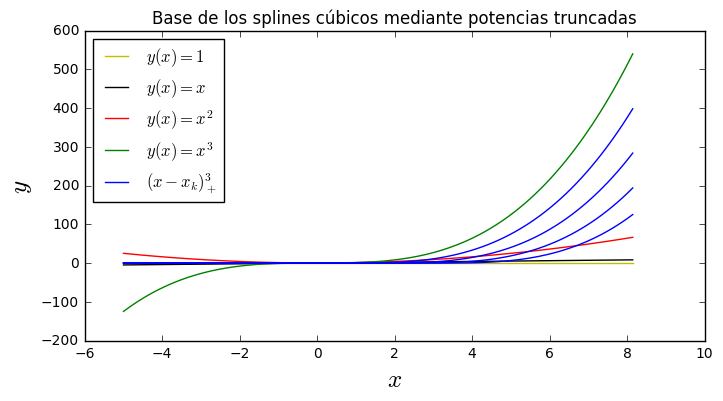

In [18]:
nxx = 100
xx = np.linspace(float(x[0]-5),float(x[-1]+5),nxx)

fig,ax = plt.subplots(figsize=(8,4))
yy = np.ones(nxx); plt.plot(xx,yy,'y',label='$y(x)=1$')
yy = xx; plt.plot(xx,yy,'k',label='$y(x)=x$')
yy = xx**2; plt.plot(xx,yy,'r',label='$y(x)=x^2$')
yy = xx**3; plt.plot(xx,yy,'g',label='$y(x)=x^3$')
for k in range(1,n):
    yy = potrunc(xx-float(x[k]),3)
    plt.plot(xx,yy,'b');  # ,label='$(x-x_i)_+$'
yy = potrunc(xx-float(x[n]),3)
plt.plot(xx,yy,'b',label='$(x-x_k)^3_+$')
ax.legend(loc=2)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Base de los splines cúbicos mediante potencias truncadas');

## Interpolación spline de Hermite

### Interpolación spline de Hermite de clase $\mathcal{C}^1$

Una situación diferente se tiene si hay que construir una función spline cúbica conocidos sus valores y los de su derivada primera
en los nodos de interpolación, pues aparece un problema de interpolación de Hermite (de clase $\mathcal{C}^1$). La construcción del spline es, en este caso, muy simple, pues se puede determinar intervalo a intervalo resolviendo un problema de interpolación de Hermite polinómico como los ya vistos. El interpolante así definido en principio sólo será de clase $\mathcal{C}^1$, no $\mathcal{C}^2$.

Desarrollamos un ejemplo, manteniendo los nodos de interpolación y la función que ya hemos empleado anteriormente.

In [62]:
nxx = 100
nzz = nxx/(n+1)
xx = np.linspace(float(x[0]),float(x[-1]),nxx)
yy = f_vec(xx)

Sólo nos queda formar una lista con los valores de la derivada de la función en los nodos de interpolación para poder ir construyendo una a una los trozos de cúbica correspondientes.

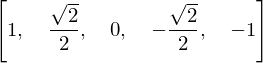

In [63]:
d = [df(z) for z in x] 
d

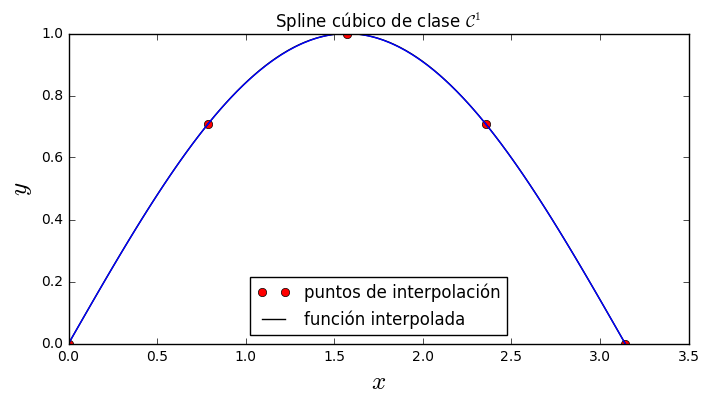

In [64]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    yk = [cubicaconderivadas(z,x[k-1],y[k-1],d[k-1],x[k],y[k],d[k]) 
          for z in zz]
    plt.plot(zz,yk,'b');

ax.legend(loc=8)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Spline cúbico de clase $\mathcal{C}^1$');

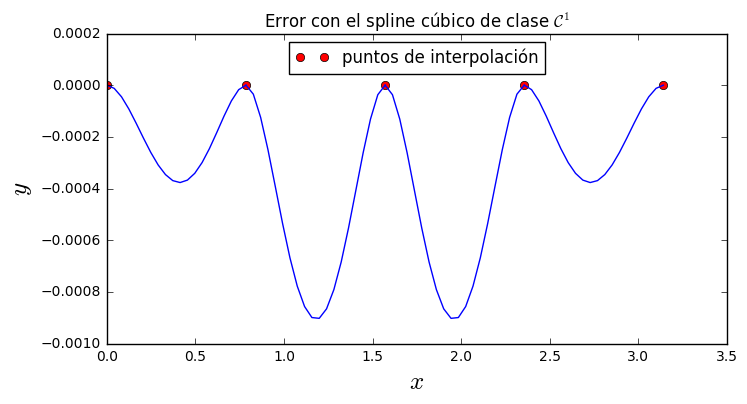

In [65]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,np.zeros(len(x)),'ro',label='puntos de interpolación')
# ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    errork = [cubicaconderivadas(z,
            x[k-1],y[k-1],d[k-1],x[k],y[k],d[k])-f(z) for z in zz]
    plt.plot(zz,errork,'b');

ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Error con el spline cúbico de clase $\mathcal{C}^1$');

## Interpolación spline de Hermite de clase $\mathcal{C}^2$

In [66]:
d2f(z)

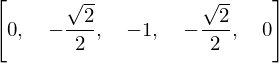

In [67]:
d2 = [d2f(z) for z in x]
d2

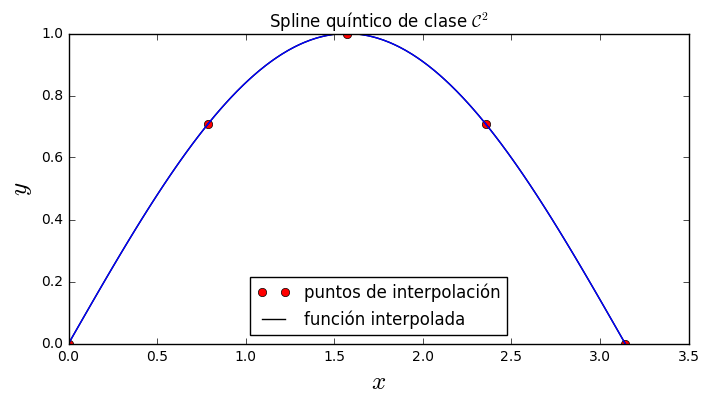

In [68]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    yk = [quintica(z,
     x[k-1],y[k-1],d[k-1],d2[k-1],x[k],y[k],d[k],d2[k]) for z in zz]
    plt.plot(zz,yk,'b');

ax.legend(loc=8)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Spline quíntico de clase $\mathcal{C}^2$');

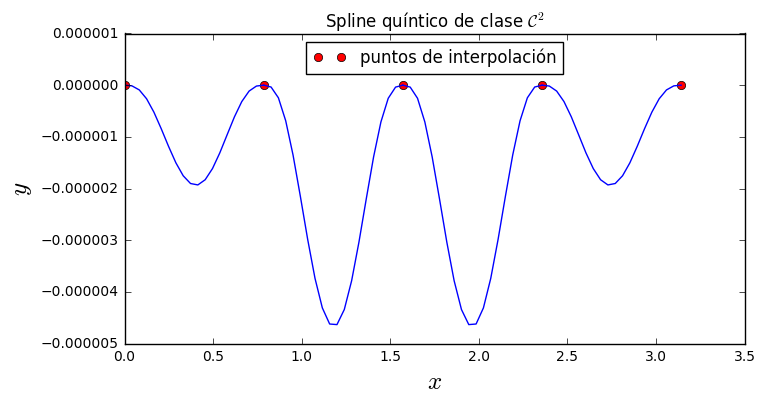

In [69]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,np.zeros(len(x)),'ro',label='puntos de interpolación')
# ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    yk = [quintica(z,x[k-1],y[k-1],d[k-1],d2[k-1]
                   ,x[k],y[k],d[k],d2[k])-f(z) for z in zz]
    plt.plot(zz,yk,'b');

ax.legend(loc=9)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Spline quíntico de clase $\mathcal{C}^2$');

No debe extraerse como conclusión que debe trabajarse siempre con interpolación spline de Hermite, pues, en la mayor parte de las situaciones prácticas, no se conocen los datos relativos a la derivada. La interpolación spline lagrangiana y la de Hermite son dos técnicas de interpolación diferentes y cada una de ellas se aplica en un contexto concreto.

## Usando la órden `interpolate` del módulo `SciPy`

In [70]:
np.random.random(10)*2

array([ 0.31102814,  0.86225395,  0.87212264,  0.94504464,  0.44112491,
        1.54305159,  1.97063972,  0.68494994,  1.45963944,  0.32381327])

In [71]:
nx = 8
x  = np.array([i for i in range(nx)])
y  = np.random.random(nx)*10

In [72]:
y

array([ 5.00445309,  1.8916754 ,  6.11563565,  3.46596627,  9.9933852 ,
        5.39380736,  6.26788641,  9.55820607])

In [74]:
def fRunge(x):   # primero definimos la función con la que vamos
    """función 1/(x**2+1) """
    return 1/(x**2+1)   # a efectuar los cálculos en este caso y la
fRunge_vec = np.vectorize(fRunge) # vectorizamos como habitualmente

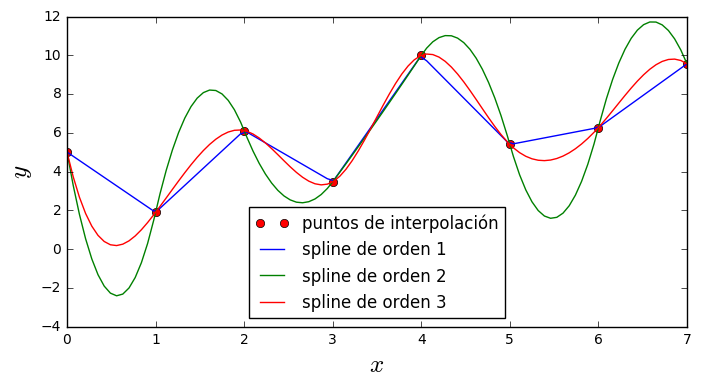

In [77]:
nxx = 100
xx = np.linspace(x[0],x[-1],nxx+1)
yy = fRunge_vec(xx)
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(x,y,'ro',label='puntos de interpolación')

for n in range(1,4):
    f = interpolate.interp1d(x,y,kind=n)
    ax.plot(xx,f(xx),label = 'spline de orden %d ' % n)

ax.legend(loc=8)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18);

In [78]:
a,b = -5,5
nx = 10
x  = np.linspace(a,b,nx+1)
y  = fRunge(x)
fi = interpolate.interp1d(x,y, kind=3)

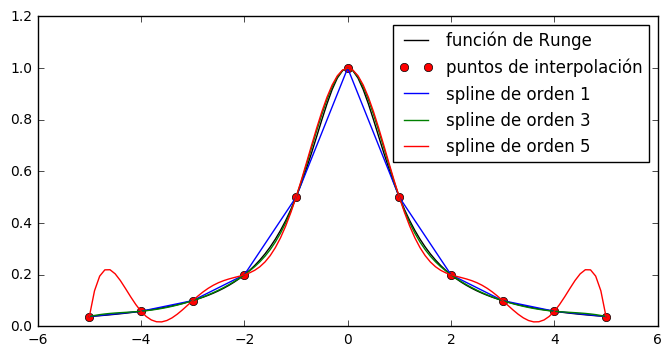

In [79]:
nxx = 100
xx = np.linspace(a,b,nxx+1)
yy = fRunge_vec(xx)
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(xx,yy,'k',label='función de Runge')
ax.plot(x,y,'ro',label='puntos de interpolación')
# ax.plot(xx,fi(xx),'r--',lw=2,label='spline cúbico')

for n in range(1,6,2):
    f = interpolate.interp1d(x,y,kind=n)
    ax.plot(xx,f(xx),label = 'spline de orden %d ' % n)

ax.legend();

## Ejercicios

1.- Halle el spline cuadrático lagrangiano que interpola la función $f(t)=e^t\text{sen} t$ en los puntos $x_i = \frac{\pi }{6}i ,\;
i=0,\ldots,6$.

2.- Halle el spline cúbico natural que interpola la función $f(t)=\frac{\frac{6}{5}}{t^2+1+\frac{3}{5}}+\frac{1}{5}$ en los nodos resultantes al dividir el intervalo $\left[-\frac{39}{8},\frac{39}{8}\right]$ en siete partes iguales.

3.- En las mismas condiciones del ejercicio anterior, halle el spline cúbico de interpolación de Hermite de primer orden.

4.- Represente los errores de interpolación correspondientes a los tres problemas anteriores.